In [6]:
from utils.model import light
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn

# 检查设备信息
light.DeviceUtils.print_device_info()

🔍 设备检测结果:
   PyTorch版本: 2.7.1+cu128
   CUDA: ❌
   MPS (Apple Silicon): ❌
   推荐设备: cpu


In [7]:
from torch._tensor import Tensor

class BetterLeNet(light.ModernModule):
    def __init__(self, config: light.ModelConfig):
        super().__init__(config)
        self._is_classification = True
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            # nn.AvgPool2d(kernel_size=2, stride=2),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 使用MaxPool代替AvgPool
            nn.LazyConv2d(
                16,
                kernel_size=5,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.ReLU(),
            nn.LazyLinear(84),
            nn.ReLU(),
            nn.LazyLinear(config.output_size),
        )

    def compute_loss(self, y_hat, y) -> Tensor:
        return nn.functional.cross_entropy(y_hat, y)

    def predict(self, x: Tensor):
        return self.net(x).argmax(dim=1)

    def predict_class(self, x: Tensor) -> Tensor:
        return self.predict(x).item()

    def evaluate(self, X, y):
        # 评估模型性能
        # 整体正确率 - FP - FN - F1score - AUC
        with torch.no_grad():
            y_hat = self.net(X)
            loss = self.compute_loss(y_hat, y)
            predicted_class = self.predict(X)
            accuracy = (predicted_class == y).float().mean().item()
            return {
                "loss": loss.item(),
                "accuracy": accuracy,
                "predicted_class": predicted_class,
            }


In [8]:
# 移植后的使用方式
import numpy as np
from scipy.stats import rankdata
from infonet.infer import load_model, estimate_mi

# 加载预训练模型
config_path = "../../configs/infonet/config.yaml"
ckpt_path = "../../data/checkpoint/infonet_cp/model_5000_32_1000-720--0.16.pt"
model = load_model(config_path, ckpt_path)


In [9]:
datapath = "../../data/"

color_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10的RGB均值
            std=[0.2023, 0.1994, 0.2010],  # CIFAR-10的RGB标准差
        ),
    ]
)
# 加载 CIFAR-10 数据集
cifar10_train = datasets.CIFAR10(
    root=datapath, train=True, download=True, transform=color_transforms
)

cifar10_test = datasets.CIFAR10(
    root=datapath,
    train=False,
    download=True,
    transform=color_transforms,  # 测试时不使用数据增强
)

# 创建数据加载器
train_loader = DataLoader(
    cifar10_train, 
    batch_size=128, 
    shuffle=True, 
)

val_loader = DataLoader(
    cifar10_test, 
    batch_size=128, 
    shuffle=False, 
)

num_classes = 10  # CIFAR-10 有10个类别
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"CIFAR-10 数据集类别数: {num_classes}")
print(f"类别名称: {class_names}")
print(f"训练集大小: {len(cifar10_train)}")
print(f"测试集大小: {len(cifar10_test)}")

CIFAR-10 数据集类别数: 10
类别名称: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
训练集大小: 50000
测试集大小: 10000


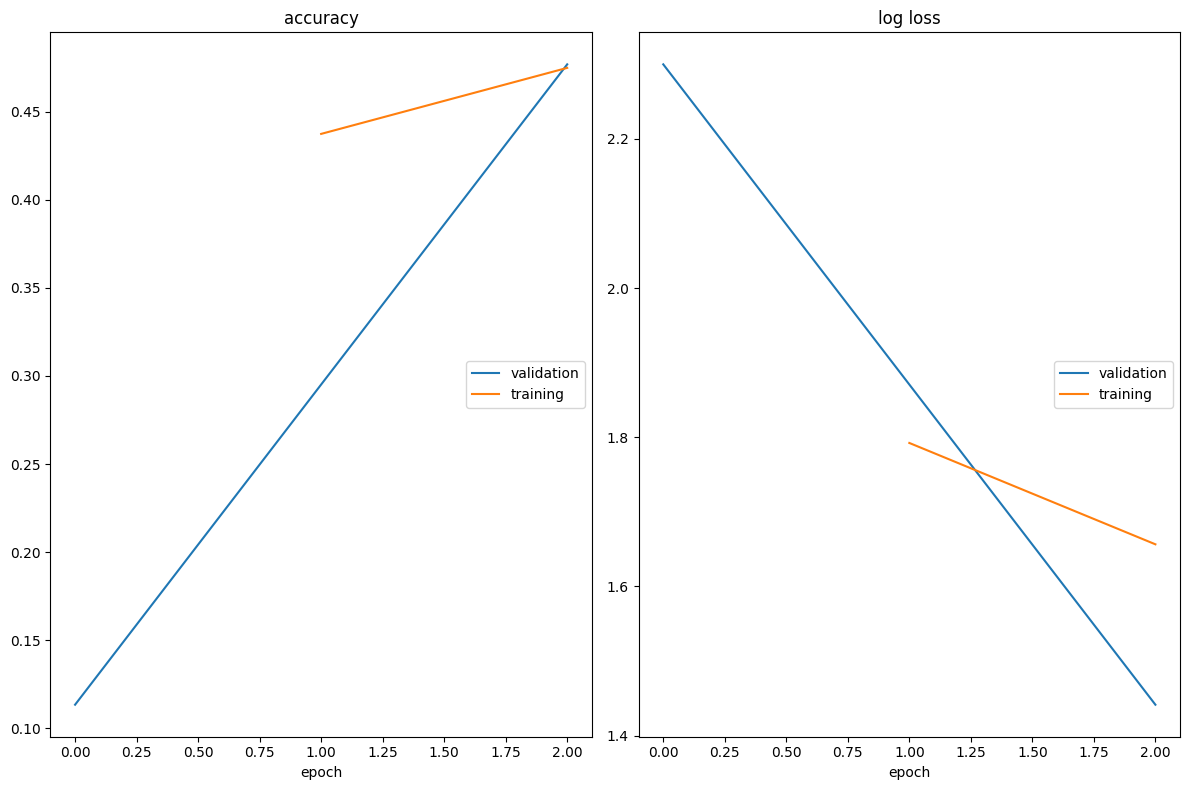

accuracy
	validation       	 (min:    0.113, max:    0.477, cur:    0.477)
	training         	 (min:    0.438, max:    0.475, cur:    0.475)
log loss
	validation       	 (min:    1.441, max:    2.300, cur:    1.441)
	training         	 (min:    1.656, max:    1.792, cur:    1.656)
Epoch 0: 100%|██████████| 391/391 [00:24<00:00, 15.90it/s, v_num=9, train_loss=1.470, train_acc=0.475, val_loss=1.440, val_acc=0.477]🔍 Epoch 0 - InfoNet MI分析中...
❌ SMI估计失败，回退到简化版本: [enforce fail at alloc_cpu.cpp:116] data. DefaultCPUAllocator: not enough memory: you tried to allocate 2048000000 bytes.


: 

In [10]:
# 创建普通的LeNet模型
from utils.model import callback


config = light.ModelConfig(
    lr=0.001,
    num_hiddens=256,
    output_size=num_classes,
    optimizer="adam",
    weight_decay=0.0001,  
)
model_lenet = BetterLeNet(config)  # 使用原始的简洁LeNet
mi_callback = callback.FilePersistentMutualInformationCallback(
    mi_model=model,
    eval_loader=val_loader,
    eval_every_n_epochs=1,
    save_dir="./mi_analysis",  # 结果保存目录
    experiment_name="lenet_cifar10_v2"  # 实验名称
)
live_callback = callback.EnhancedHighFrequencyLiveLossPlotCallback(
    update_every_n_batches=200
)

trainer = light.TrainerFactory.basic(
    max_epochs=10,
)
    
trainer.add_callback(mi_callback)
trainer.add_callback(live_callback)

trainer.fit(
    model_lenet, 
    train_loader=train_loader, 
    val_loader=val_loader
)


🎯 训练完成！分析结果...

📊 MI分析汇总报告 - lenet_cifar10_v1
📈 最新结果 (Epoch 9):
--------------------------------------------------
conv1   : I(X;T)=0.1608, I(T;Y)=0.1448
conv2   : I(X;T)=0.0578, I(T;Y)=0.0691
fc1     : I(X;T)=0.0065, I(T;Y)=0.1877
fc2     : I(X;T)=0.0148, I(T;Y)=0.2330
fc3     : I(X;T)=0.0187, I(T;Y)=0.1913

📊 变化趋势:
--------------------------------------------------
conv1: I(X;T) ↗️ (+0.0464), I(T;Y) ➡️ (+0.0001)
conv2: I(X;T) ↗️ (+0.0313), I(T;Y) ↘️ (-0.0193)
fc1: I(X;T) ↘️ (-0.0143), I(T;Y) ↗️ (+0.0906)
fc2: I(X;T) ↗️ (+0.0110), I(T;Y) ↗️ (+0.0824)
fc3: I(X;T) ↘️ (-0.0404), I(T;Y) ↘️ (-0.0528)
📄 详细报告已保存: ./mi_analysis\lenet_cifar10_v1_summary.txt


C:\Src\SevFoxie\SevFoxie\Study\2025Summer\DeepLearning\code\src\utils\model\callback.py:485: UserWarning: Glyph 21464 (\N{CJK UNIFIED IDEOGRAPH-53D8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Src\SevFoxie\SevFoxie\Study\2025Summer\DeepLearning\code\src\utils\model\callback.py:485: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Src\SevFoxie\SevFoxie\Study\2025Summer\DeepLearning\code\src\utils\model\callback.py:485: UserWarning: Glyph 36235 (\N{CJK UNIFIED IDEOGRAPH-8D8B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Src\SevFoxie\SevFoxie\Study\2025Summer\DeepLearning\code\src\utils\model\callback.py:485: UserWarning: Glyph 21183 (\N{CJK UNIFIED IDEOGRAPH-52BF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Src\SevFoxie\SevFoxie\Study\2025Summer\DeepLearning\code\src\utils\model\callback.py:489: UserWarning: Glyph 21464 (\N{CJK UNIFIED IDEOGRAPH-53D8}) missing from font(s) Deja

📊 趋势图已保存: ./mi_analysis\lenet_cifar10_v1_mi_trends.png


c:\Src\SevFoxie\SevFoxie\Study\2025Summer\DeepLearning\code\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21464 (\N{CJK UNIFIED IDEOGRAPH-53D8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Src\SevFoxie\SevFoxie\Study\2025Summer\DeepLearning\code\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Src\SevFoxie\SevFoxie\Study\2025Summer\DeepLearning\code\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36235 (\N{CJK UNIFIED IDEOGRAPH-8D8B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Src\SevFoxie\SevFoxie\Study\2025Summer\DeepLearning\code\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21183 (\N{CJK UNIFIED IDEOGRAPH-52BF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


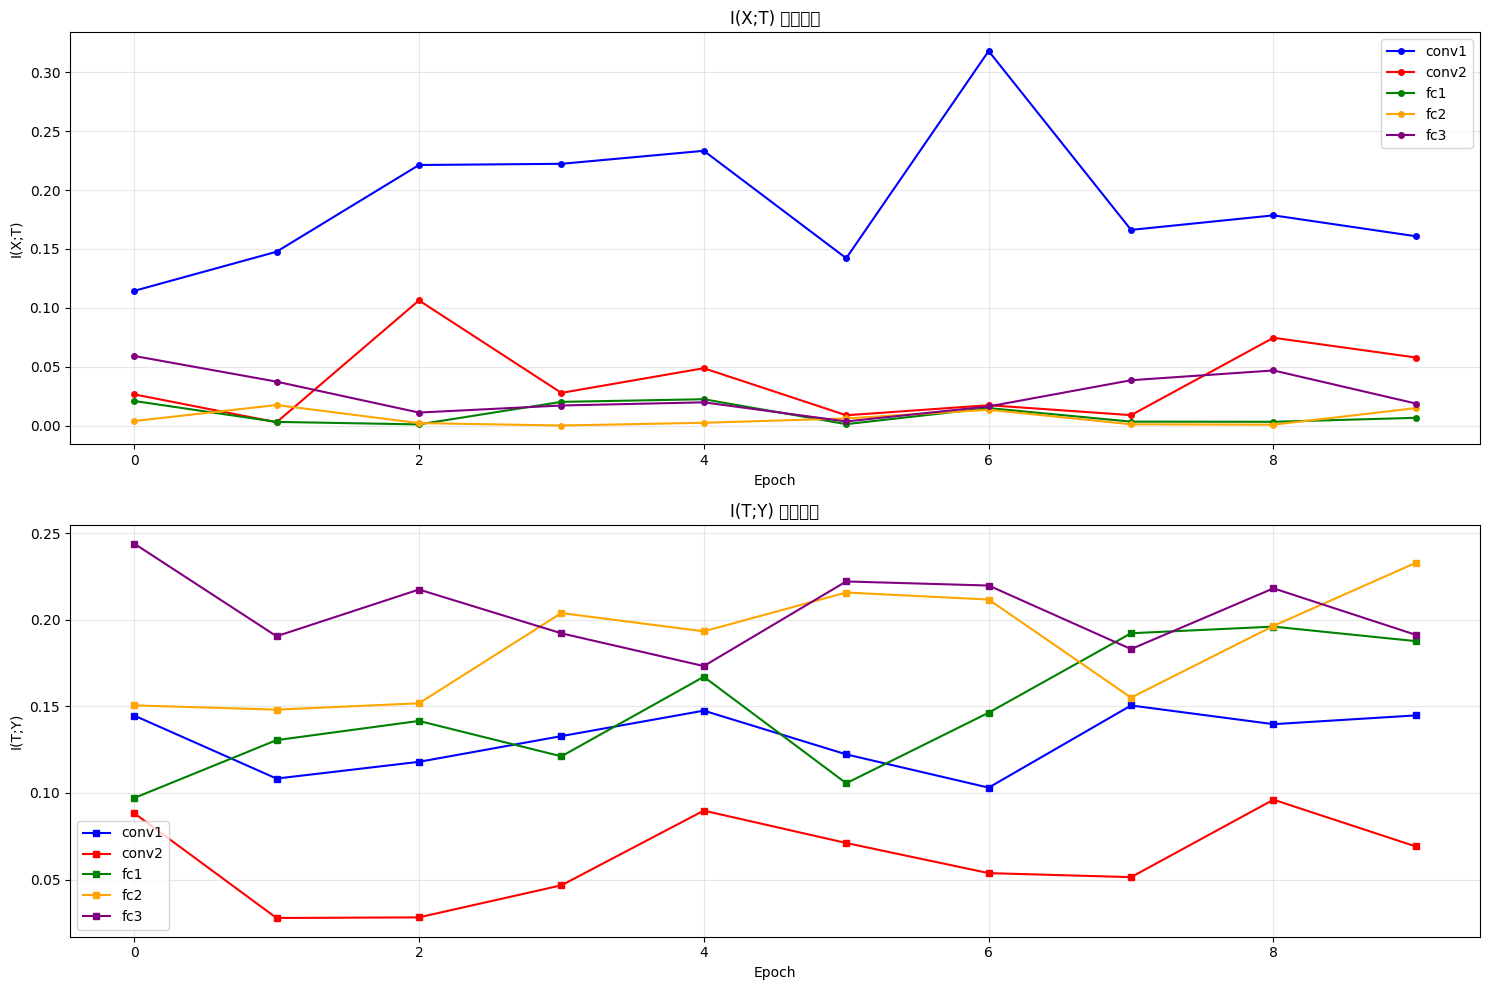


📊 共收集了 50 条MI数据记录


In [6]:

# 训练完成后分析结果
print("\n🎯 训练完成！分析结果...")
mi_callback._show_periodic_summary()  # 显示最终汇总
mi_callback.plot_mi_trends()  # 绘制趋势图

# 获取数据进行自定义分析
df = mi_callback.get_results_dataframe()
print(f"\n📊 共收集了 {len(df)} 条MI数据记录")